# Set up 

In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp

print(os.getcwd())

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


c:\Users\user\Documents\research\BMCA-pipeline\notebooks\all_data


In [2]:
os.chdir('../../..')
from src import BMCA, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/topologyB/all_data/')

# Perturbing enzymes

In [3]:
ant ='../../../data/interim/Antimony/JSexample22.ant'  

data_file01 = '../../../data/interim/generated_data/JSexample22/JSexample22_0.1.csv'
data_file02 = '../../../data/interim/generated_data/JSexample22/JSexample22_0.2.csv'
data_file03 = '../../../data/interim/generated_data/JSexample22/JSexample22_0.3.csv'
data_file04 = '../../../data/interim/generated_data/JSexample22/JSexample22_0.4.csv'
data_file05 = '../../../data/interim/generated_data/JSexample22/JSexample22_0.5.csv'
data_file10 = '../../../data/interim/generated_data/JSexample22/JSexample22_1.01.csv'

r = te.loada(ant)
r.conservedMoietyAnalysis = True
r.steadyState()

# data_files = [data_file05, data_file10, data_file15, data_file3, data_file5, data_file7, data_file100]

1.5710734600032811e-15

In [ ]:
BMCA_obj01 = BMCA.BMCA(ant, data_file01)
BMCA_obj02 = BMCA.BMCA(ant, data_file02)
BMCA_obj03 = BMCA.BMCA(ant, data_file03)
BMCA_obj04 = BMCA.BMCA(ant, data_file04)
BMCA_obj05 = BMCA.BMCA(ant, data_file05)
BMCA_obj10 = BMCA.BMCA(ant, data_file10)


In [5]:
def run_ADVI(BMCA_obj):
    with pm.Model() as pymc_model:
        
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=BMCA_obj.en.T)
        chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BMCA_obj.xn.T)
        y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BMCA_obj.yn.T)
        likelihood = pm.Deterministic('vn', e_obs * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
    
        N_ITERATIONS = 45000
    
    with pymc_model:
        advi = pm.ADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=       N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
    
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    return approx.sample(draws=1000, random_seed=1)


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2,880.9


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,868


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,381


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,195.9


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,125.8


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,030.3


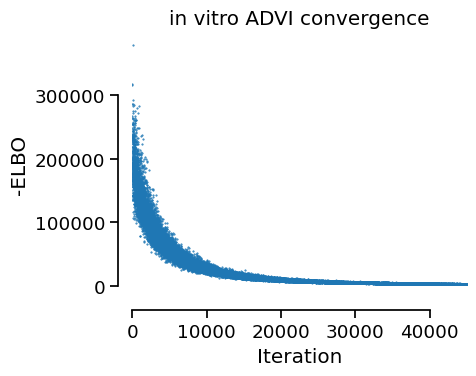

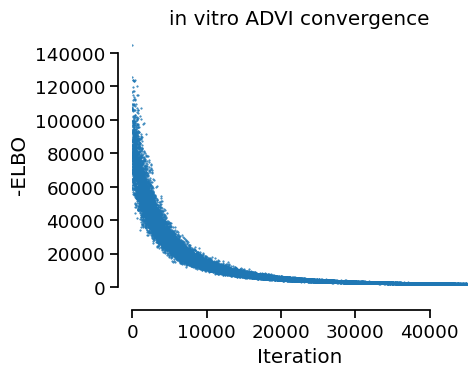

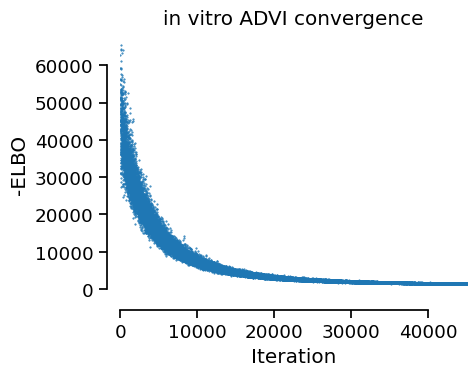

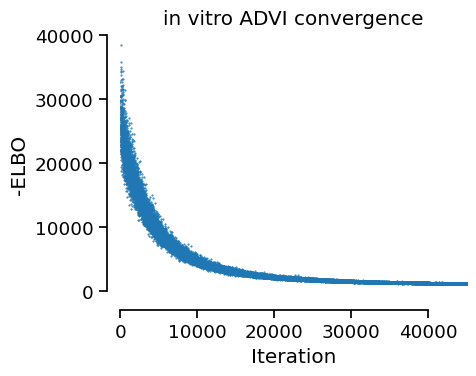

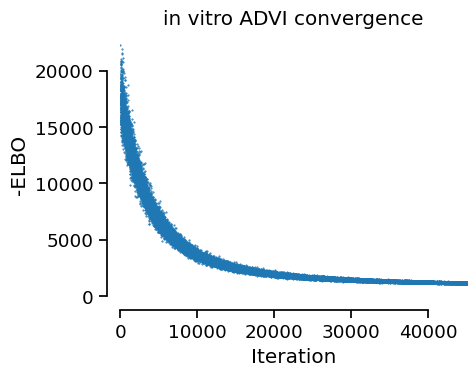

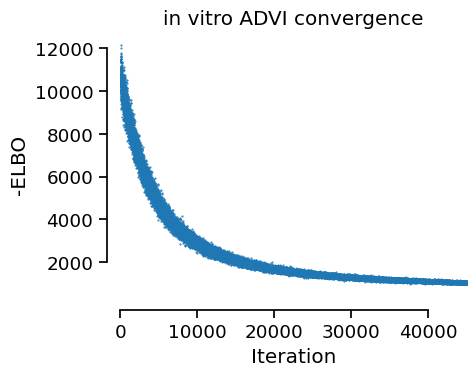

In [6]:
trace01 = run_ADVI(BMCA_obj01)
trace02 = run_ADVI(BMCA_obj02)
trace03 = run_ADVI(BMCA_obj03)
trace04 = run_ADVI(BMCA_obj04)
trace05 = run_ADVI(BMCA_obj05)
trace10 = run_ADVI(BMCA_obj10)


In [7]:
ExTrace_01 = (trace01['posterior']['Ex']).to_numpy().squeeze()
ExTrace_02 = (trace02['posterior']['Ex']).to_numpy().squeeze()
ExTrace_03 = (trace03['posterior']['Ex']).to_numpy().squeeze()
ExTrace_04 = (trace04['posterior']['Ex']).to_numpy().squeeze()
ExTrace_05 = (trace05['posterior']['Ex']).to_numpy().squeeze()
ExTrace_10 = (trace10['posterior']['Ex']).to_numpy().squeeze()


In [8]:
medEx_01 = np.median(ExTrace_01, axis=0)
medEx_02 = np.median(ExTrace_02, axis=0)
medEx_03 = np.median(ExTrace_03, axis=0)
medEx_04 = np.median(ExTrace_04, axis=0)
medEx_05 = np.median(ExTrace_05, axis=0)
medEx_10 = np.median(ExTrace_10, axis=0)


In [10]:
# first regulator, H on v5
a = [pd.DataFrame(r.getScaledElasticityMatrix(), columns=r.getFloatingSpeciesIds(), index=r.getReactionIds()).loc['v5']]
for i in [medEx_01, medEx_02, medEx_03, medEx_04, medEx_05, medEx_10]:
    aa = pd.DataFrame(i, index=r.getReactionIds(), columns=r.getFloatingSpeciesIds()).loc['v5']
    a.append(aa)
a = pd.concat(a, axis=1)
a.set_axis(['gt', '0.1x','0.2x','0.3x','0.4x','0.5x', '1.01x'], axis='columns') 

,gt,0.1x,0.2x,0.3x,0.4x,0.5x,1.01x
G6P,0.000000,0.013963,0.004676,0.006997,-0.000121,0.001439,0.000406
TRIO,0.000000,0.036072,0.002394,0.002701,0.002345,-0.003491,-0.006767
ACE,0.000000,0.058168,0.022454,0.009605,-0.004438,-0.000448,-0.006518
P3G,0.000000,0.003113,-0.005439,-0.001128,0.004421,0.001902,-0.003028
PEP,0.000000,0.002687,-0.004598,0.007820,-0.000420,-0.000126,-0.002926
GLCi,0.000000,-0.013855,0.008610,0.011461,0.003169,0.003222,0.005994
F6P,1.383026,1.172368,1.450640,1.411735,1.338005,1.208332,0.985786
BPG,0.000000,0.011688,0.001153,-0.004842,-0.003489,0.005880,0.001777
PYR,0.000000,0.006865,-0.000714,0.003290,0.001306,0.002517,-0.006305
F16P,-1.036885,-0.899901,-1.116847,-1.076770,-0.976787,-0.880184,-0.779213


In [11]:
# second regulator, O on v15
a = [pd.DataFrame(r.getScaledElasticityMatrix(), columns=r.getFloatingSpeciesIds(), index=r.getReactionIds()).loc['v15']]
for i in [medEx_01, medEx_02, medEx_03, medEx_04, medEx_05, medEx_10]:
    aa = pd.DataFrame(i, index=r.getReactionIds(), columns=r.getFloatingSpeciesIds()).loc['v15']
    a.append(aa)
a = pd.concat(a, axis=1)
a.set_axis(['gt', '0.1x','0.2x','0.3x','0.4x','0.5x', '1.01x'], axis='columns') 

,gt,0.1x,0.2x,0.3x,0.4x,0.5x,1.01x
G6P,1.403469,1.583172,1.254810,1.329229,1.233379,1.308568,0.951176
TRIO,0.000000,0.010467,0.012536,0.009061,0.005220,0.002668,0.002885
ACE,0.000000,0.000721,0.014446,-0.003456,-0.001925,-0.008741,0.007281
P3G,0.000000,0.003092,0.010750,0.007314,-0.001585,0.006442,0.000378
PEP,0.000000,0.000855,0.004767,0.002415,0.000812,0.003471,-0.000804
GLCi,0.000000,0.001710,0.001807,-0.002967,0.002247,-0.001380,0.006306
F6P,-0.953057,-1.132821,-0.849677,-0.898613,-0.827444,-0.858701,-0.906472
BPG,0.000000,0.007007,0.014632,0.004203,-0.005141,-0.000375,-0.004561
PYR,0.000000,0.007245,-0.003950,-0.003610,0.001549,0.000146,-0.005582
F16P,0.000000,0.005748,0.002032,0.006214,-0.005266,0.008027,0.000107


## Calculating FCCs

In [12]:
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

In [13]:
def estimate_CCs(BMCA_obj, Ex):
    BMCA_obj.vn[BMCA_obj.vn == 0] = 1e-6
    
    a = np.diag(BMCA_obj.en.values / BMCA_obj.vn.values)
    a = np.diag(a)
    a = a[np.newaxis,:].repeat(1000, axis=0)

    Ex_ss = a @ Ex
    As = BMCA_obj.N @ np.diag(BMCA_obj.v_star) @ Ex_ss
    bs = BMCA_obj.N @ np.diag(BMCA_obj.v_star)
    bs = bs[np.newaxis, :].repeat(1000, axis=0)
    
    As = at.as_tensor_variable(As)
    bs = at.as_tensor_variable(bs)

    def solve_aesara(A, b):
        rsolve_op = LeastSquaresSolve()
        return rsolve_op(A, b).squeeze()

    CCC, _ = aesara.scan(lambda A, b: solve_aesara(A, b),
                        sequences=[As, bs], strict=True)

    identity = np.eye(len(BMCA_obj.N.T))
    identity = identity[np.newaxis,:].repeat(1000, axis=0)
    
    FCC = (Ex_ss @ CCC.eval()) + identity
    
    # return CCC.eval(), FCC
    return FCC


### Negative predictions

In [14]:
postFCC01 = estimate_CCs(BMCA_obj01, ExTrace_01)
postFCC02 = estimate_CCs(BMCA_obj02, ExTrace_02)
postFCC03 = estimate_CCs(BMCA_obj03, ExTrace_03)
postFCC04 = estimate_CCs(BMCA_obj04, ExTrace_04)
postFCC05 = estimate_CCs(BMCA_obj05, ExTrace_05)
postFCC10 = estimate_CCs(BMCA_obj10, ExTrace_10)


In [15]:
rxn_FCCs = [postFCC01,postFCC02,postFCC03,postFCC04,postFCC05, postFCC10]
pt_labels = ['0.1x','0.2x','0.3x','0.4x','0.5x', '1.01x']

In [16]:
def append_FCC_df(postFCC, label):
    dfs=[]
    
    for idx, rxn in enumerate(r.getReactionIds()):
        # negativity applied here
        df = -pd.DataFrame(postFCC[:,idx,:], columns=r.getReactionIds())
        df['pt_rxn']=[rxn]*len(df)
        dfs.append(df)
    
    w = pd.concat(dfs)
    w['pt_str']=[label]*len(w)
    return w

prd_FCCs = pd.concat([append_FCC_df(rxn_FCCs[i], pt_labels[i]) for i in range(len(rxn_FCCs))])

In [17]:
medPrdFCCs = pd.pivot_table(prd_FCCs, index=['pt_rxn','pt_str'], aggfunc='median', sort=False)
# medPrdFCCs.loc['vGLK']
medPrdFCCs.head()

,,vGLK,vPGI,vGLYCO,vTreha,vPFK,vALD,vGAPDH,vPGK,vPGM,vENO,vPYK,vPDC,vSUC,vGLT,vADH,vG3PDH
pt_rxn,pt_str,,,,,,,,,,,,,,,,
vGLK,0.1x,-1.800291,0.025338,0.015183,0.155203,0.083029,0.022895,0.010400,0.004605,0.003658,0.002036,0.002612,0.000540,-0.002364,0.478968,-0.005698,0.003724
vPGI,0.1x,0.234341,-1.906697,-0.038323,-0.391750,0.324271,0.098579,0.040596,0.019295,0.017940,0.014632,0.020971,0.014070,-0.010195,0.560849,-0.024573,0.021066
vGLYCO,0.1x,0.135989,-0.030455,-1.022838,-0.233460,-0.104968,-0.033169,-0.011723,-0.007300,-0.007928,-0.006576,-0.010168,-0.009295,0.003001,0.325789,0.007235,-0.009113
vTreha,0.1x,0.169546,-0.035987,-0.027928,-1.285483,-0.128667,-0.043479,-0.015728,-0.008367,-0.009660,-0.008883,-0.013358,-0.010740,0.003823,0.406550,0.009214,-0.011693
vPFK,0.1x,0.234341,0.093303,-0.038323,-0.391750,-1.675729,0.098579,0.040596,0.019295,0.017940,0.014632,0.020971,0.014070,-0.010195,0.560849,-0.024573,0.021066


### Graphing the averaged differences between ground truth and predicted distributions

C:\Users\user\AppData\Local\Temp\ipykernel_1900\3859003407.py:12: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



<Figure size 1600x1000 with 0 Axes>

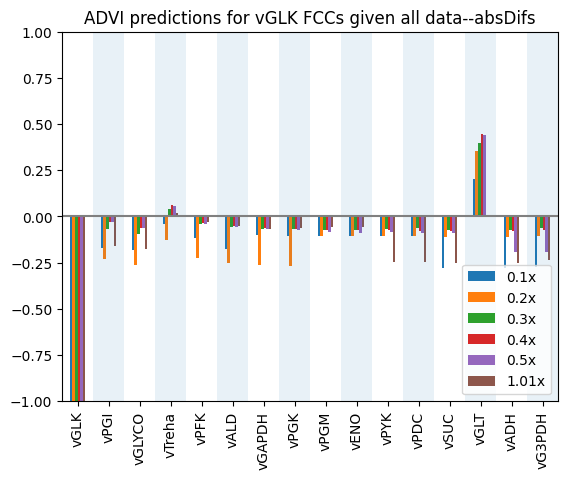

<Figure size 1600x1000 with 0 Axes>

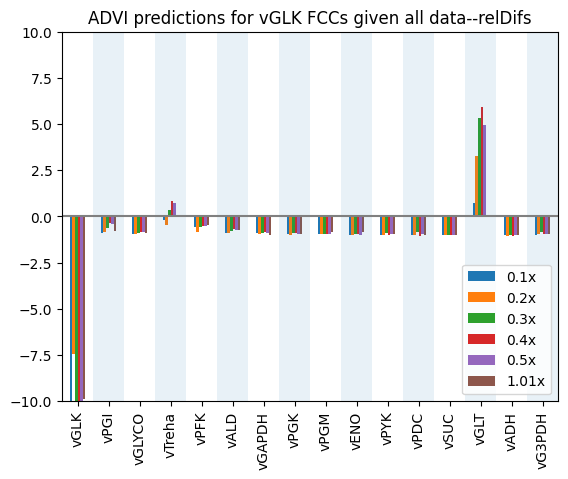

<Figure size 1600x1000 with 0 Axes>

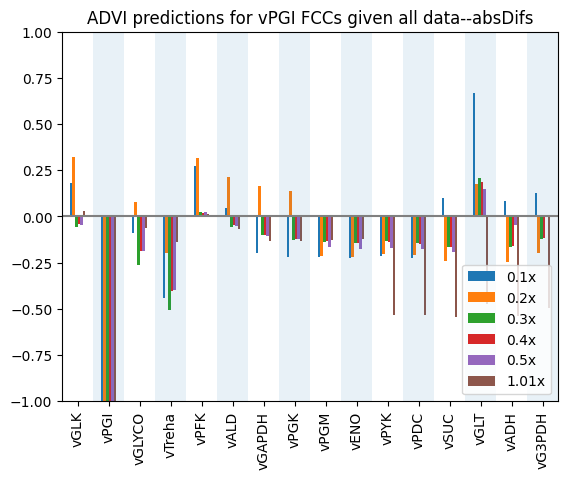

<Figure size 1600x1000 with 0 Axes>

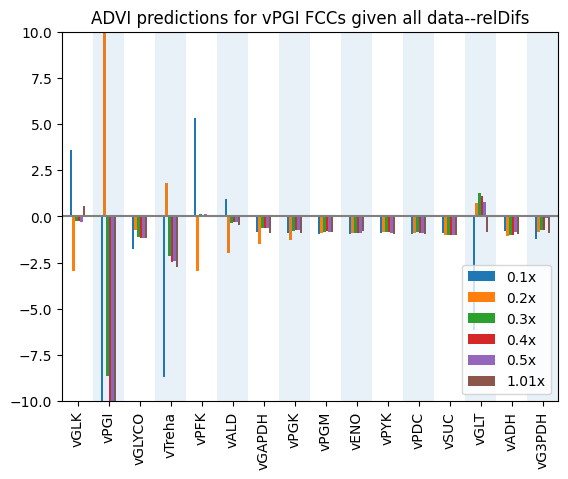

<Figure size 1600x1000 with 0 Axes>

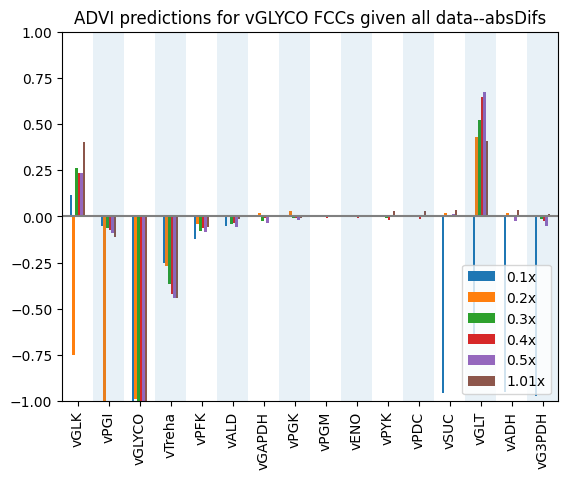

<Figure size 1600x1000 with 0 Axes>

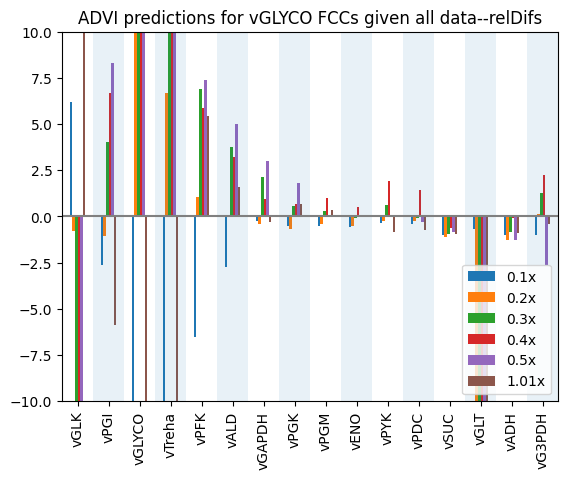

<Figure size 1600x1000 with 0 Axes>

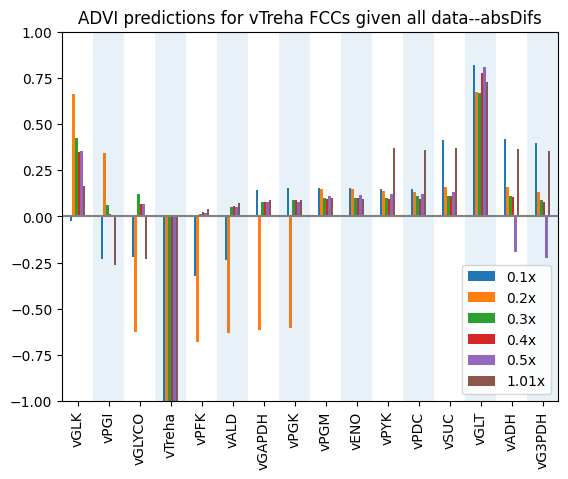

<Figure size 1600x1000 with 0 Axes>

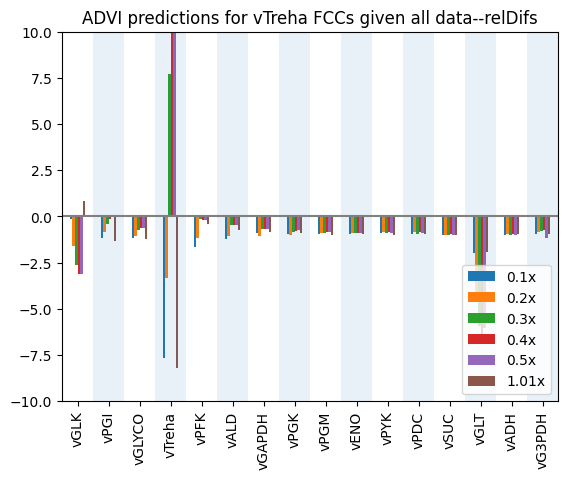

<Figure size 1600x1000 with 0 Axes>

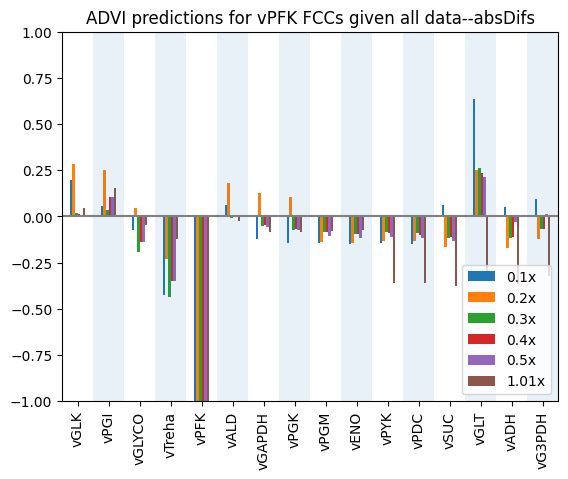

<Figure size 1600x1000 with 0 Axes>

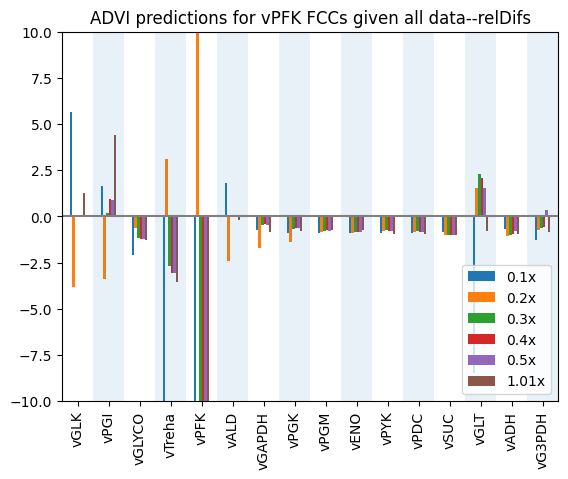

<Figure size 1600x1000 with 0 Axes>

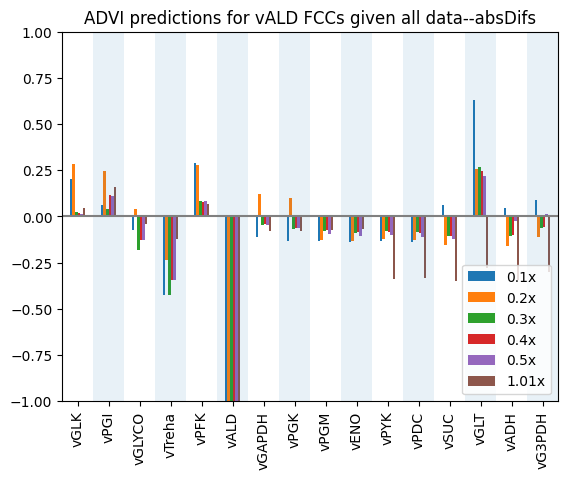

<Figure size 1600x1000 with 0 Axes>

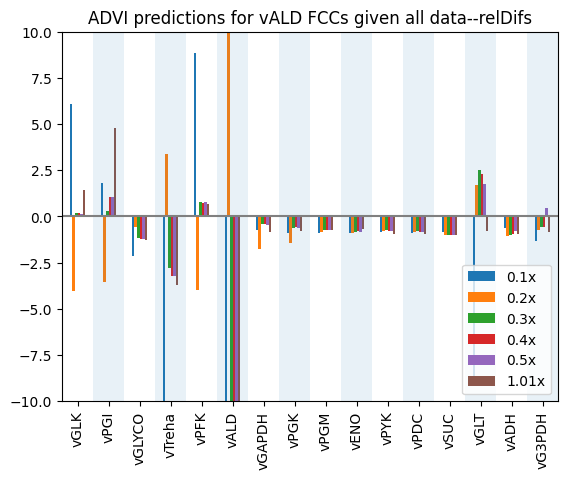

<Figure size 1600x1000 with 0 Axes>

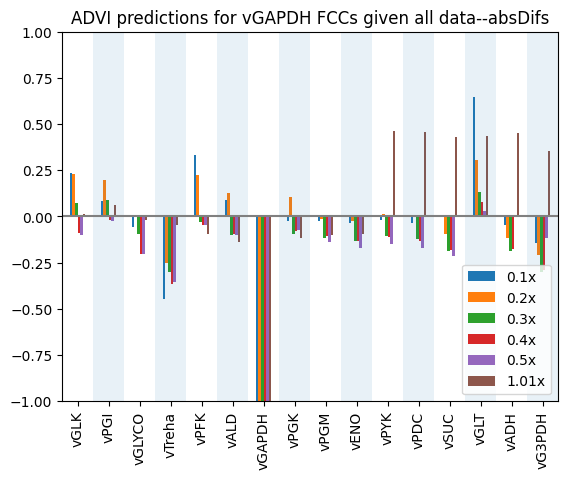

<Figure size 1600x1000 with 0 Axes>

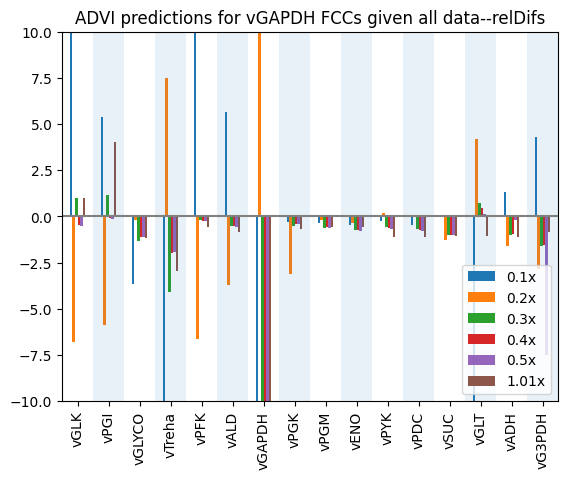

<Figure size 1600x1000 with 0 Axes>

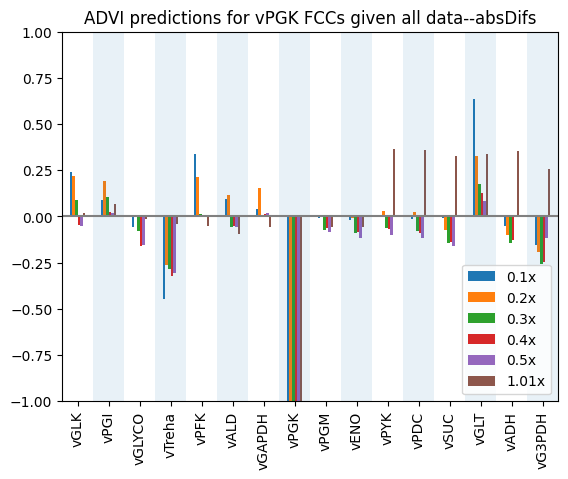

<Figure size 1600x1000 with 0 Axes>

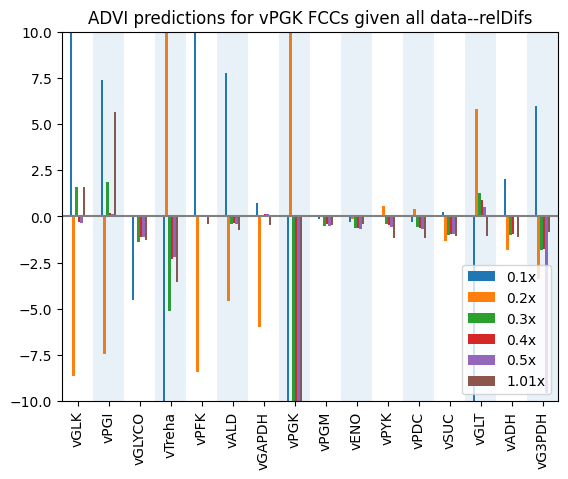

<Figure size 1600x1000 with 0 Axes>

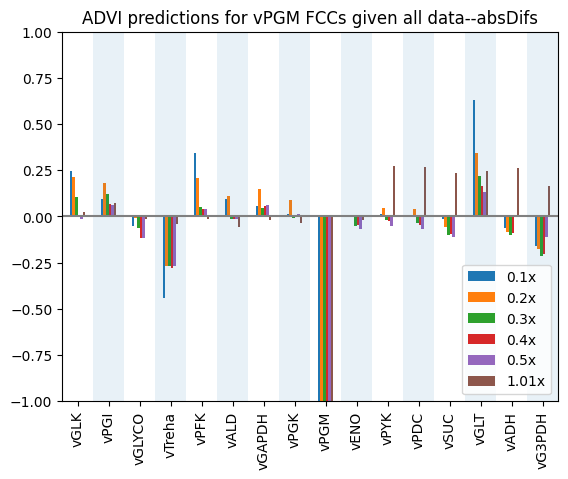

<Figure size 1600x1000 with 0 Axes>

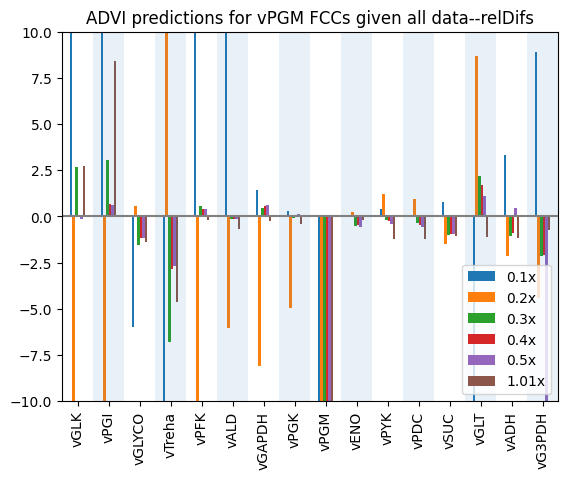

<Figure size 1600x1000 with 0 Axes>

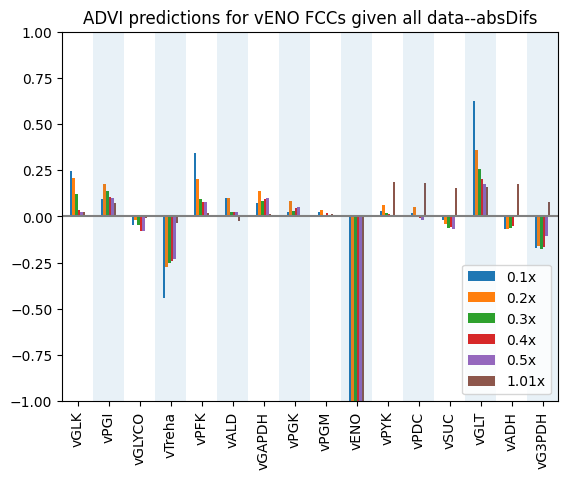

<Figure size 1600x1000 with 0 Axes>

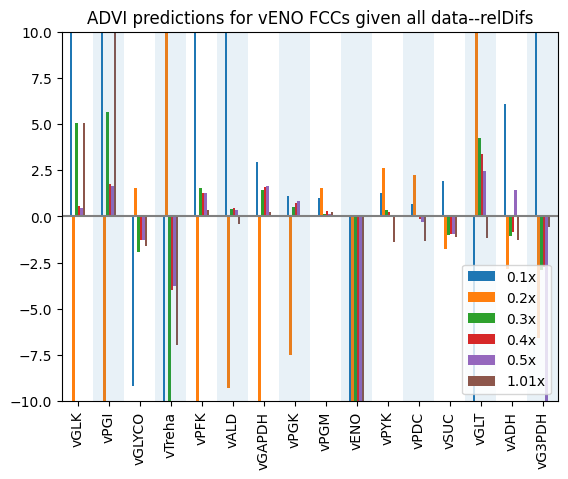

<Figure size 1600x1000 with 0 Axes>

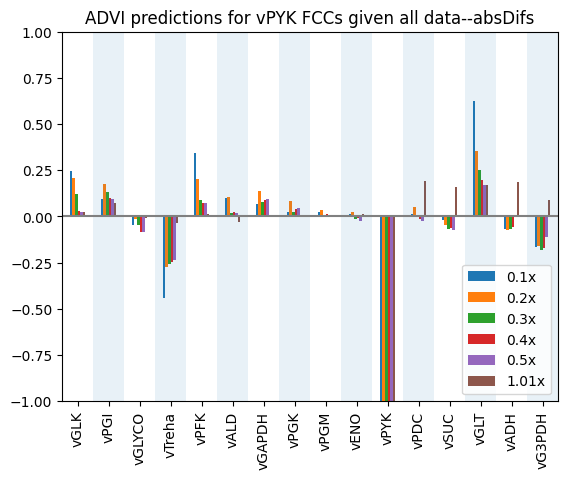

<Figure size 1600x1000 with 0 Axes>

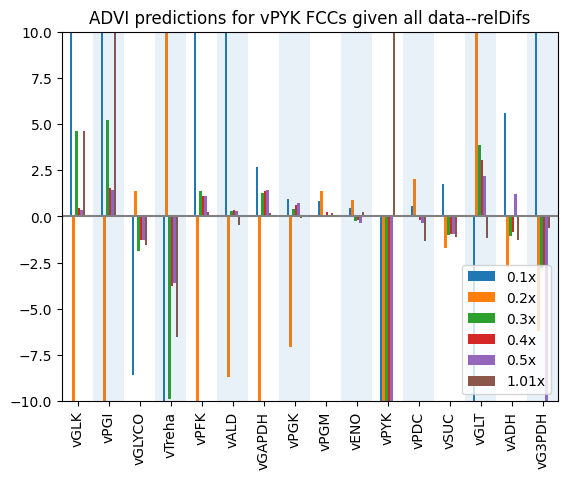

<Figure size 1600x1000 with 0 Axes>

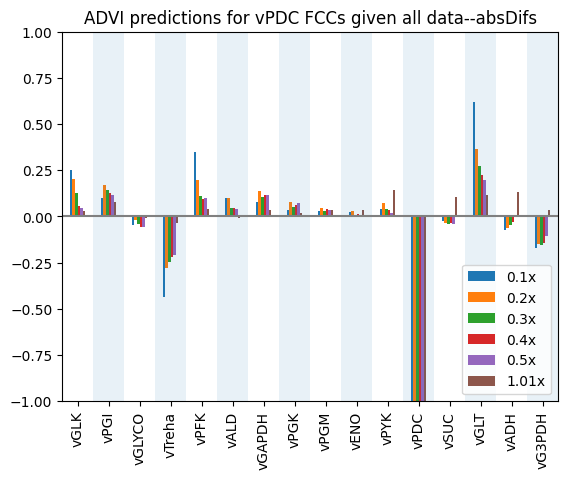

<Figure size 1600x1000 with 0 Axes>

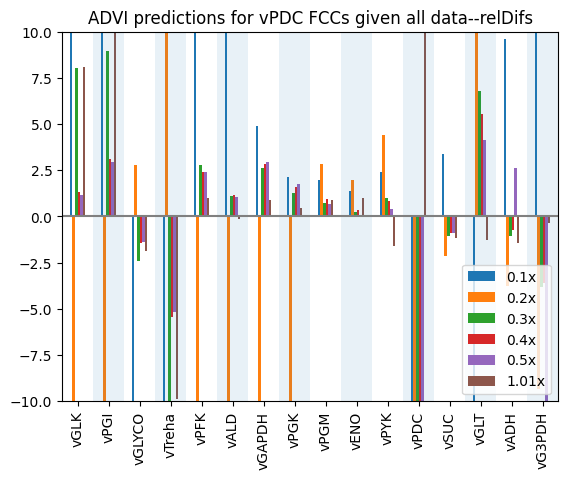

<Figure size 1600x1000 with 0 Axes>

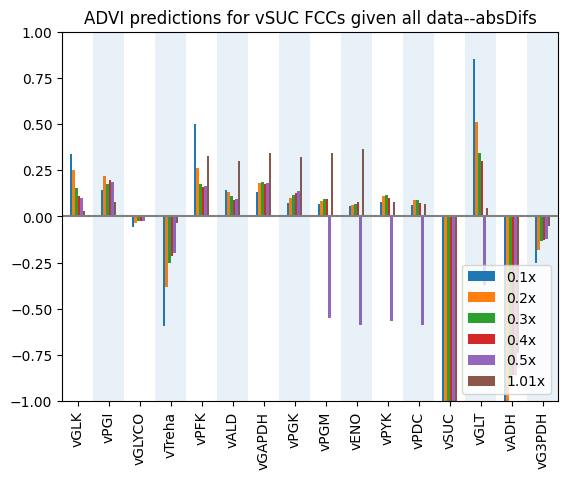

<Figure size 1600x1000 with 0 Axes>

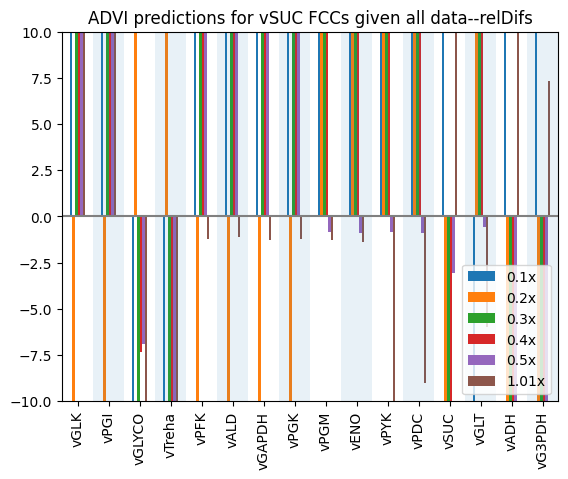

<Figure size 1600x1000 with 0 Axes>

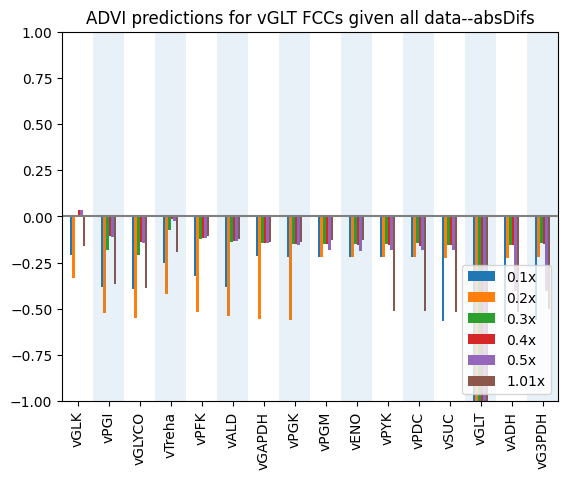

<Figure size 1600x1000 with 0 Axes>

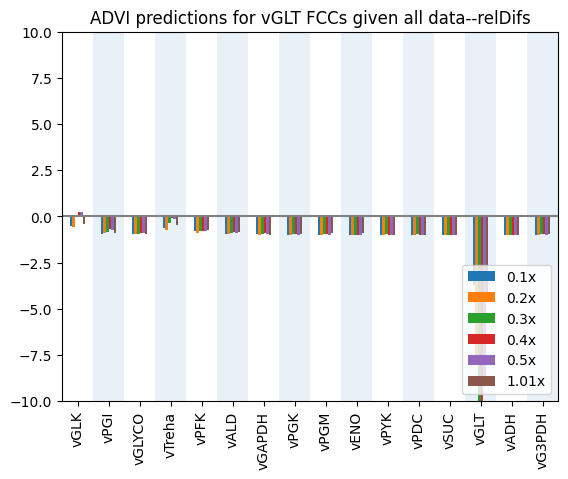

<Figure size 1600x1000 with 0 Axes>

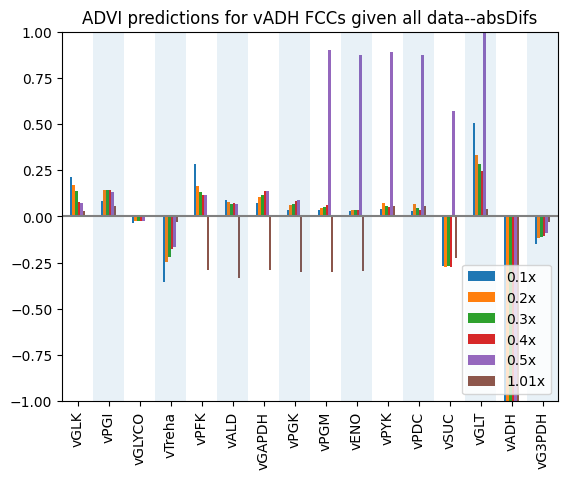

<Figure size 1600x1000 with 0 Axes>

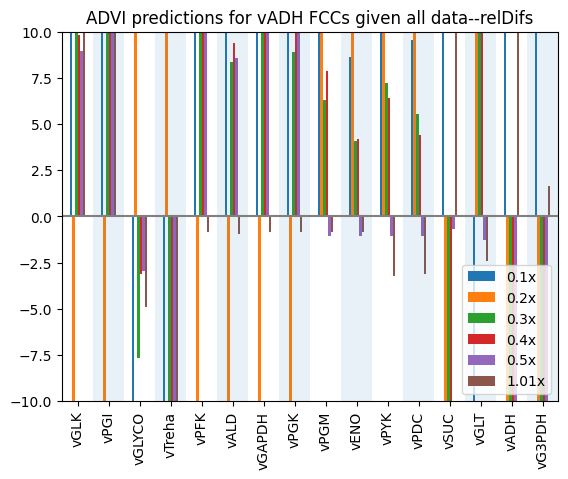

<Figure size 1600x1000 with 0 Axes>

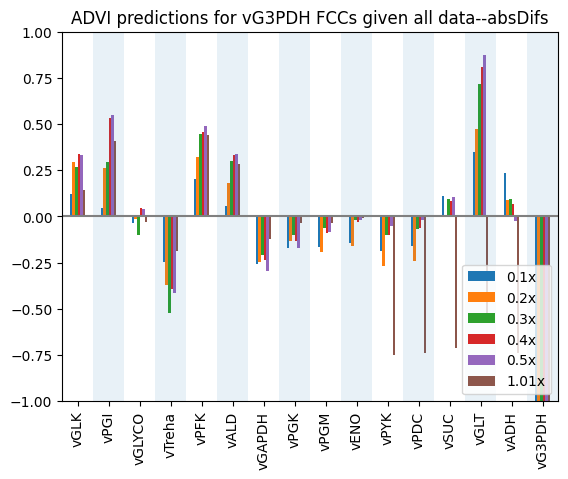

<Figure size 1600x1000 with 0 Axes>

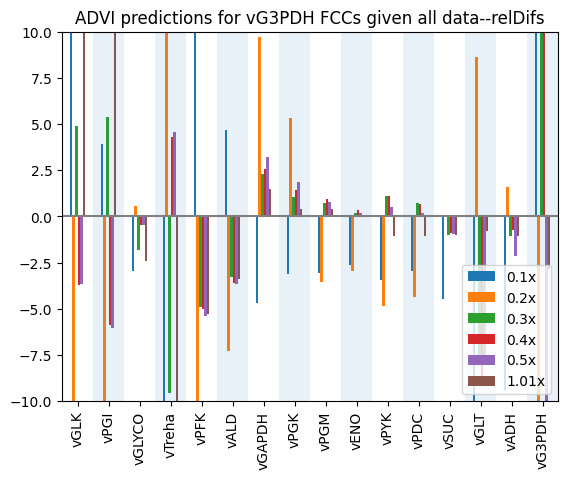

In [18]:
# for each reaction that can be perturbed
for rxn in r.getReactionIds():
    # locate the applicable rows in the medPrdFCCs df
    a = medPrdFCCs.loc[rxn]
    gtvals = np.repeat(gtFCC[rxn].values, repeats=len(pt_labels), axis=0).reshape((len(pt_labels), -1))
    # calculate the absolute difference...
    absDifs = a - gtvals
    # and the relative difference
    relDifs = absDifs/gtvals
    
    # plot both graphs 
    f1 = plt.figure(figsize=(16, 10))
    absDifs.T.plot(kind='bar')
    # alternate color each group of reactions so it is easier to see
    for i in range(8):
            plt.axvspan(2*i + 0.5, 2*i + 1.5, alpha=0.1)
    plt.axhline(0, c='gray')
    plt.ylim((-1,1))
    plt.legend(loc='lower right')
    plt.title(f'ADVI predictions for {rxn} FCCs given all data--absDifs')

    f2 = plt.figure(figsize=(16, 10))
    relDifs.T.plot(kind='bar')
    # alternate color each group of reactions so it is easier to see
    for i in range(8):
            plt.axvspan(2*i + 0.5, 2*i + 1.5, alpha=0.1)
    plt.axhline(0, c='gray')
    plt.ylim((-10,10))
    plt.legend(loc='lower right')
    plt.title(f'ADVI predictions for {rxn} FCCs given all data--relDifs')

In [19]:
plt.close("all")

## Evaluating FCC ranking

In [20]:
gtFCC=pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
gtFCC = pd.DataFrame(np.select([m1], [float('Nan')], gtFCC), columns=gtFCC.columns, index=gtFCC.index)
gtFCC_rankings= gtFCC.rank(axis=1, ascending=False, na_option='keep')
# gtFCC_rankings

In [21]:
m1 = gtFCC_rankings.isin([1.0])  
m2 = gtFCC_rankings.isin([2.0])  
m3 = gtFCC_rankings.isin([3.0])  
a = m1.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)
b = m2.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)
c = m3.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)

trueRanks = pd.concat([a,b,c], axis=1)
trueRanks['topThree'] = trueRanks[0] + trueRanks[1] + trueRanks[2]

In [22]:
rxn_FCCs = [postFCC01,postFCC02,postFCC03,postFCC04,postFCC05, postFCC10]
scores = []
for pt_level in rxn_FCCs:
    postFCC_med=pd.DataFrame(np.median(pt_level, axis=0), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
    # m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
    postFCC_med = pd.DataFrame(np.select([m1], [float('Nan')], postFCC_med), columns=gtFCC.columns, index=gtFCC.index)
    postFCC_med_rankings= postFCC_med.rank(axis=1, ascending=False, na_option='keep')
  
    m1 = postFCC_med_rankings.isin([1.0])  
    m2 = postFCC_med_rankings.isin([2.0])  
    m3 = postFCC_med_rankings.isin([3.0])  
    a = m1.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)
    b = m2.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)
    c = m3.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)

    prdRanks = pd.concat([a,b,c], axis=1)
    prdRanks['topThree'] = prdRanks[0] + prdRanks[1] + prdRanks[2]

    scores.append([len([i for i in prdRanks['topThree'][rxn] if i in trueRanks['topThree'][rxn]]) for rxn in r.getReactionIds()])

topThreeCheckdf = pd.DataFrame(scores, columns=r.getReactionIds(), index=pt_labels).T

In [23]:
topThreeCheckdf.style.background_gradient(cmap='RdYlBu', axis=None)
# sns.heatmap(topThreeCheckdf, annot=True, cmap='RdYlBu')

,0.1x,0.2x,0.3x,0.4x,0.5x,1.01x
vGLK,1,2,2,3,2,3
vPGI,2,2,2,3,2,2
vGLYCO,2,3,2,3,2,3
vTreha,1,2,1,3,2,3
vPFK,2,2,2,3,2,2
vALD,1,1,1,2,1,2
vGAPDH,1,1,1,2,1,1
vPGK,1,1,1,2,1,1
vPGM,1,1,1,2,1,1
vENO,1,1,1,2,1,2


In [24]:
topThreeCheckdf.sum(axis=0)

0.1x     17
0.2x     23
0.3x     19
0.4x     36
0.5x     20
1.01x    31
dtype: int64

In [25]:
for i in r.getReactionIds():
    a = gtFCC_rankings.loc[i].values
    b = postFCC_med_rankings.loc[i].values
    spcorr = stats.spearmanr(a,b,nan_policy='omit')
    print(i, spcorr)

vGLK SpearmanrResult(correlation=0.882142857142857, pvalue=1.3558210624788787e-05)
vPGI SpearmanrResult(correlation=0.8142857142857142, pvalue=0.000219365827727102)
vGLYCO SpearmanrResult(correlation=0.9142857142857143, pvalue=1.8531121308926186e-06)
vTreha SpearmanrResult(correlation=0.8571428571428571, pvalue=4.446004447004746e-05)
vPFK SpearmanrResult(correlation=0.8285714285714285, pvalue=0.0001352447801327695)
vALD SpearmanrResult(correlation=0.8285714285714285, pvalue=0.0001352447801327695)
vGAPDH SpearmanrResult(correlation=0.3928571428571428, pvalue=0.14746665531132622)
vPGK SpearmanrResult(correlation=0.44642857142857145, pvalue=0.09529321315352618)
vPGM SpearmanrResult(correlation=0.46428571428571425, pvalue=0.08125098075549496)
vENO SpearmanrResult(correlation=0.5392857142857143, pvalue=0.038021656263557906)
vPYK SpearmanrResult(correlation=0.4607142857142857, pvalue=0.08393338135031411)
vPDC SpearmanrResult(correlation=0.4428571428571429, pvalue=0.09829406554687131)
vSUC Sp